# Основы анализа данных в Python

*Алла Тамбовцева*

## Практикум: метод k-ближайших соседей (работа с датафреймами)

**Глобальная задача:** используя метод k-ближайших соседей, научиться предсказывать вид пингвина на основе его числовых характеристик (пример из лекции).

**Локальные задачи:**

* изучить распределение пингвинов по классам и распределение числовых характеристик пингвинов;
* разделить выборку на обучающую и тестовую;
* обучить алгоритм методом k-ближайших соседей для предсказания класса на основе обучающих данных (k=3);
* оценить качество алгоритма на тестовых данных;
* используя k-fold кросс-валидацию, подобрать число соседей k, которое обещает наилучшее качество предсказания.

### Подготовка к работе

Импортируем необходимые библиотеки:

* `pandas`: для работы с датафреймами;
* `numpy`: для работы с массивами;
* `seaborn`: для более удобной визуализации.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

Выключим появление сообщений с предупреждениями (немного неспортивно, но предупреждения от `seaborn` нестрашные, у нас в фокусе внимания будут не графики, а метод k-ближайших соседей).

In [2]:
import warnings
warnings.filterwarnings('ignore')

Зафиксируем глобальные настройки графиков – белый фон и координатная сетка:

In [3]:
# чтобы графики были более симпатичными, чем в классическом matplotlib
# сетка = grid

sns.set(style = "whitegrid")

Загрузим данные по пингвинам, удалим строки с пропущенными значениями и сохраним изменения:

In [4]:
# источник данных: 

pin = pd.read_csv("penguins.csv")
pin.dropna(inplace = True)

In [5]:
pin.columns

Index(['Unnamed: 0', 'species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')

Данные по пингвинам взяты с Kaggle ([источник](https://www.kaggle.com/datasets/larsen0966/penguins)), переменные в файле:

* `species`: вид пингвина (Adelie – Адели, Gentoo – Генту, Chinstrap – антарктический пингвин);
* `island`: остров обитания;
* `bill_length_mm`: длина клюва, в мм;
* `bill_depth_mm`: глубина клюва, в мм;
* `flipper_length_mm`: длина плавников (крыльев), в мм;
* `body_mass_g`: вес пингвина, в граммах;
* `sex`: пол пингвина;
* `year`: год наблюдения.

Для начала посмотрим, пингвины каких видов есть в датафрейме:

In [6]:
pin["species"].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

Три вида, пингвинов вида Chinstrap меньше, чем остальных, но, в целом, нельзя сказать, что группы очень разные по размеру. 

Сравним пингвинов разных видов по массе тела – построим ящики с усами для наглядности:

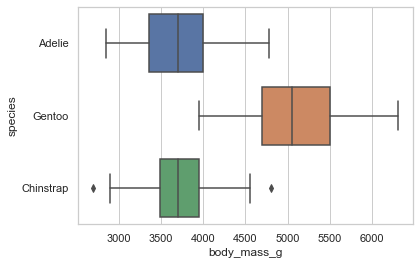

In [7]:
# функция boxplot()
# x – числовой показатель
# y – показатель группировки

sns.boxplot(data = pin, x = "body_mass_g", y = "species");

Пингвины вида Генту – самые тяжелые, распределение веса пингвинов Адели и антарктических пингвинов примерно одинаковое, только среди антарктических пингвинов встречаются нетипично мелкие или крупные особи (выбросы). 

Изучим распределение длины клюва у разных видов:

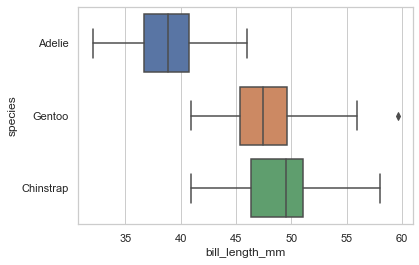

In [8]:
sns.boxplot(data = pin, x = "bill_length_mm", y = "species");

Вот тут распределения у всех трех групп точно разные, медианы отличаются, разброс значений тоже. О чем это говорит? О том, что если мы будем использовать вес пингвинов и длину их клюва для определения вида, классификация будет вполне удачной, поскольку пингвины разных видов отличаются по этим показателям. Посмотрим на совместное распределение этих показателей – построим диаграмму рассеивания и отметим цветом принадлежность к виду:

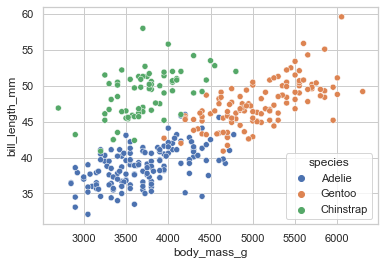

In [9]:
# функция scatterplot()
# hue: цвет точек, который зависит от переменной в данных, здесь от species

sns.scatterplot(data = pin, x = "body_mass_g", y = "bill_length_mm", hue = "species");

На диаграмме рассеивания тоже видны различия – точки, соответствующие разным видам пингвинов, образуют три разные группы:
    
* Адели: легкие пингвины с коротким клювом;
* Генту: легкие пингвины с длинным клювом;
* Антарктические пингвины: тяжелые пингвины с длинным клювом.

Чтобы понимать – вот они (Адели, Генту и антарктические):

<table>
    <tr>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Hope_Bay-2016-Trinity_Peninsula%E2%80%93Ad%C3%A9lie_penguin_%28Pygoscelis_adeliae%29_04.jpg" width="120"></td>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/b/b0/Antarctic%2C_gentoo_penguin_%28js%29_16.jpg" width="255">
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/0/08/South_Shetland-2016-Deception_Island%E2%80%93Chinstrap_penguin_%28Pygoscelis_antarctica%29_04.jpg" width="112"></td>
    </tr>

### Обучение и тестирование алгоритма: метод k-ближайших соседей

Импортируем необходимые функции из библиотеки `sklearn` для машинного обучения:

* `train_test_split`: для разбиения набора данных на обучающую и тестовую выборку;
* `StandardScaler`: для нормирования данных;
* `KNeighborsClassifier`: для создания knn-классификатора (*knn* – от *k nearest neighbours*);
* `accuracy_score`, `confusion_matrix`: для оценки качества.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

Выберем необходимые для обучения столбцы и сохраним их как `X` и `Y`:

In [11]:
# входные переменные, признаки
# перечисляем названия в виде списка, первые квадратные скобки – для выбора,
# вторые – границы списка

X = pin[["bill_length_mm", "body_mass_g"]]
X.head()

,bill_length_mm,body_mass_g
0,39.1,3750.0
1,39.5,3800.0
2,40.3,3250.0
4,36.7,3450.0
5,39.3,3650.0


In [12]:
# целевая переменная, отклик

Y = pin["species"]
Y.head()

0    Adelie
1    Adelie
2    Adelie
4    Adelie
5    Adelie
Name: species, dtype: object

Разделим данные на обучающую выборку и тестовую выборку в соотношении 80% к 20% (доля наблюдений в обучающей выборке – примерно 0.8 от исходных данных, доля наблюдений в тестовой выборке – примерно 0.2):

In [13]:
# X, Y исходные данные
# test_size: доля наблюдений в тестовой выборке
# random_state: для воспроизводимости

x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.2, 
                                                    random_state = 123)

Функция `train_test_split()` умеет случайным образом выбирать желаемую долю наблюдений из двух датафреймов для обучающей и тестовой выборок. В данном случае мы хотели получить тестовую выборку из 20% исходных наблюдений (`test_size = 0.2`) на основе датафреймов `X` и `Y`. К тому же, чтобы у всех получились одинаковые результаты, мы зафиксировали стартовую точку алгоритма, который осуществляет случайное разделение на обучающую и тестовую выборки (`random_state = 123`), теперь у всех, у кого в этом аргументе указано 123, будут одинаковые наблюдения в этих выборках. 

Посмотрим на результаты – что в `x_train`, `x_test`, `y_train` и `y_test`:

In [14]:
x_train.head() # случайно выбранные строки из X, обычный датафрейм

,bill_length_mm,body_mass_g
342,50.8,4100.0
214,45.7,4400.0
97,40.3,4350.0
298,43.2,2900.0
204,45.1,4400.0


In [15]:
x_test.head() # случайно выбранные строки из X, обычный датафрейм

,bill_length_mm,body_mass_g
111,45.6,4600.0
158,45.4,4800.0
291,50.5,4050.0
311,47.5,3900.0
186,49.1,5150.0


In [16]:
y_train.head() # случайно выбранные строки из Y, обычный Series (столбец)

342    Chinstrap
214       Gentoo
97        Adelie
298    Chinstrap
204       Gentoo
Name: species, dtype: object

In [17]:
y_test.head() # случайно выбранные строки из Y, обычный Series (столбец)

111       Adelie
158       Gentoo
291    Chinstrap
311    Chinstrap
186       Gentoo
Name: species, dtype: object

Размерности для понимания данных:

In [18]:
print("Train set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Train set: (266, 2) (266,)
Test set: (67, 2) (67,)


Так как данные представлены в разных шкалах (миллиметры и граммы) и имеют разный разброс значений, выполним нормализацию для перехода к безразмерным величинам. Мы будем проводить стандартизацию – вычитать из каждого значения переменной ее среднее и делить на стандартное отклонение. Для этого можно воспользоваться готовой функцией `StandardScaler()` из `sklearn`, которая создает объект класса *scaler*, позволяющий производить стандартизацию и сохранять ее результаты.

In [19]:
scaler = StandardScaler() # просто резервируем место для результатов

Теперь можно применить методы `.fit_transform()` и `.transform()` для стандартизации:

In [20]:
X_train = scaler.fit_transform(x_train) # преобразуем тренировочные данные X
X_test = scaler.transform(x_test) # преобразуем тестовые данные X

Почему понадобилось два разных метода, `.fit_transform()` для обучающей выборки и `.transform()` для тестовой? Ответ простой: по идее, мы должны были выполнить стандартизацию в самом начале, до разбиения наблюдений на две выборки, то есть использовать для этого средние и дисперсии, посчитанные по всему датафрейму из 333 пингвинов. А у нас сейчас датафрейм из 266 строк в `x_train` и датафрейм из 67 строк в `x_test`. То есть, например, при стандартизации веса пингвинов в `x_train` среднее и дисперсия будут считаться по 266 наблюдениям, а в `x_test` – по 67 наблюдениям, что приведет к разным результатам. Чтобы нормализация данных проходила единобразно, нужна хитрость:

* метод `.fit_transform()` вычисляет среднее и стандартное отклонение всех показателей в `x_train`, сохраняет их и производит стандартизацию в `x_train`;
* метод `.transform()` забирает уже сохраненные на предыдущем шаге средние и стандартные отклонения (по обучающей выборке `x_train`) и подставляет их для стандартизации данных в тестовой выборке `x_test`.

На выходе мы получаем массивы стандартизованных значений (уже массивы, не датафреймы, но и с исходными датафреймами без стандартизации и перехода к массивам дальнейшие функции тоже будут работать):

In [21]:
X_train[0:10] # для примера

array([[ 1.27649054, -0.0978194 ],
       [ 0.32834826,  0.27701798],
       [-0.6755671 ,  0.21454508],
       [-0.13642737, -1.59716892],
       [ 0.2168021 ,  0.27701798],
       [ 1.09058028,  1.90131329],
       [-0.93584145, -0.69131192],
       [-0.13642737,  0.33949087],
       [-1.47498118, -0.90996706],
       [-0.95443248, -0.47265678]])

Теперь переходим непосредственно к классификации. Создаем объект класса *KNeighborsClassifier* – резервируем место под результаты исполнения алгоритма классификации методом k-ближайших соседей, указав, что нам нужно три ближайших соседа (k=3): 

In [22]:
# три ближайших соседа для предсказания класса 
# n_neighbors = k

neigh = KNeighborsClassifier(n_neighbors = 3)

Посмотрим на параметры классификации – какие настройки Python использует по умолчанию:

In [23]:
neigh.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

* Алгоритм `auto` – Python автоматически под наши данные выберет подходящий алгоритм для определения классов соседей (вычисление всех попарных расстояний через алгоритм `brute` и поиск ближайших точек или более умное разделение пространства на части через алгоритмы `ball_tree` или `kd_tree`).

* Число листьев `leaf_size = 30` – так как почти наверняка вместо вычисления всех попарных расстояний Python выберет более умный алгоритм, ему понадобятся решающие деревья для разделения пространства на части, поэтому выбираются деревья глубины 30 по умолчанию.

* Метрика `minkowski` со степенью `p=2` – обычное евклидово расстояние для работы с количественными данными (метрика Минковского – более общий случай, при подсчете расстояний может использоваться степень `p` вместо возведения в квадрат и корень степени `p` вместо обычного квадратного корня).

Нас все устраивает – запускаем процедуру обучения, используя метод `.fit()`:

In [24]:
# метод применяется к классификатору neigh
# на первом месте набор X, на втором – Y
# X_train и y_train: датафрейм или массив

neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Классификатор обучился, теперь внутри `neigh` хранится информация о трех ближайших соседях каждого наблюдения, а также правило, которое позволяет определять класс наблюдения на новых данных. 

Применяем обученную модель для предсказания видов пингвинов на тестовой выборке – используем метод `.predict()` и тестовые данные `X_test`:

In [25]:
predicted = neigh.predict(X_test)

В `predicted` хранится массив с метками классов – к какому классу наша модель отнесла пингвинов, чьи характеристики у нас зафиксированы в `X_test`:

In [26]:
predicted

array(['Gentoo', 'Gentoo', 'Chinstrap', 'Chinstrap', 'Gentoo', 'Adelie',
       'Chinstrap', 'Adelie', 'Chinstrap', 'Adelie', 'Adelie', 'Gentoo',
       'Gentoo', 'Gentoo', 'Adelie', 'Gentoo', 'Adelie', 'Gentoo',
       'Adelie', 'Gentoo', 'Chinstrap', 'Gentoo', 'Adelie', 'Adelie',
       'Gentoo', 'Adelie', 'Gentoo', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Gentoo', 'Adelie', 'Gentoo', 'Adelie',
       'Gentoo', 'Gentoo', 'Adelie', 'Chinstrap', 'Adelie', 'Gentoo',
       'Chinstrap', 'Adelie', 'Gentoo', 'Gentoo', 'Gentoo', 'Chinstrap',
       'Gentoo', 'Adelie', 'Chinstrap', 'Chinstrap', 'Gentoo', 'Adelie',
       'Gentoo', 'Adelie', 'Gentoo', 'Adelie', 'Gentoo', 'Gentoo',
       'Adelie', 'Gentoo', 'Gentoo', 'Chinstrap', 'Adelie', 'Adelie',
       'Gentoo'], dtype=object)

Построим *confusion matrix* – таблицу соответствий, которая позволит увидеть, в скольких случаях модель предсказала класс правильно, а в скольких – ошиблась:

In [27]:
# labels: задаем порядок классов, чтобы понимать, что где

confusion_matrix(y_test, predicted, labels = ["Adelie", "Chinstrap", "Gentoo"])

array([[25,  0,  3],
       [ 1, 10,  0],
       [ 1,  1, 26]])

Для наглядности сделаем эту матрицу маленькой таблицей с подписями:

In [28]:
# массив выше превращаем в датафрейм
# index – названия строк
# columns – названия строк

pd.DataFrame(confusion_matrix(y_test, predicted, labels =["Adelie", "Chinstrap", "Gentoo"]), 
             index = ["True Adelie", "True Chinstrap", "True Gentoo"], 
             columns = ["Predicted Adelie", "Predicted Chinstrap", "Predicted Gentoo"])

,Predicted Adelie,Predicted Chinstrap,Predicted Gentoo
True Adelie,25,0,3
True Chinstrap,1,10,0
True Gentoo,1,1,26


Итого: модель корректно предсказала вид 25 пингвинов Адели, 10 антарктических пингвинов и 26 пингвинов Генту. При этом модель ошибалась. Например, три раза отнесла пингвина Адели к виду Генту (*True* vs *Predicted*). Вычислим точность модели (*accuracy*) – долю верно предсказанных классов:

In [29]:
print("Accuracy: ", accuracy_score(y_test, predicted))

Accuracy:  0.9104477611940298


Точность вполне достойная, но при желании ее можно улучшить. Во-первых, за счет добавления новых признаков (помимо веса и длины клюва), во-вторых, за счет изменения числа ближайших соседей. Мы пойдем по второму пути и задействуем кросс-валидацию.

### Кросс-валидация и выбор числа соседей

Мы обсуждали на лекции, что существуют разные виды кросс-валидации – проверки качества модели на данных, не участвующих в обучении. В этом практикуме мы использовали самый простой способ – *holdout validation*, когда данные делятся на группы случайным образом один раз. Мы один раз поделили данные на обучающую и тестовую выборку. Этот способ имеет очевидный недостаток: если разбиение одно, результаты очень сильно зависят от этого разбиения, обобщающая сила такого подхода невелика. Тем не менее, способ рабочий, его часто применяют при работе с действительно большими данными, когда позволить себе много разных разбиений невозможно из-за большого объема и затрат по времени и памяти.

В нашем случае датафрейм небольшой, поэтому можем позволить себе более интересный способ кросс-валидации – *k-fold cross-validation*. При этом типе кросс-валидации все данные случайным образом делятся на $k$ групп (*folds*) примерно одинакового размера, и одна группа выполняет роль тестовой выборки, а все остальные $k-1$ групп выполняют роль обучающей выборки. Так, мы получаем несколько вариантов делений, и каждая группа по очереди имеет возможность побыть тестовой выборкой. Удобнее всего думать об этом в терминах циклов. 

У нас есть данные по 266 пингвинам. Если мы захотим выполнить *k-fold* кросс-валидацию с $k=10$, Python будет делать следующее:

* случайным образом разделит все данные на 10 групп примерно по 27 наблюдений (плюс-минус, 266 ровно не делится) и будет перебирать группы в цикле;
* на первом шаге цикла первую группу из 27 наблюдений он выберет в качестве тестовой, остальные девять групп «сольет» в обучающую выборку; на обучающей выборке обучит алгоритм, на тестовой измерит качество классификации;
* на втором шаге цикла вторую группу из 27 наблюдений он выберет в качестве тестовой, девять групп «сольет» в обучающую выборку; на обучающей выборке обучит алгоритм, на тестовой измерит качество классификации;
* проделает эту операцию для всех групп, в итоге на каждом шаге цикла у нас будет значение метрики качества.

В чем польза? Во-первых, результаты, полученные на разных шагах цикла, мы можем усреднить – получить более общую оценку качества, которая не зависит от одного единственного деления на группы. Во-вторых, этот механизм можно использовать в сочетании с подбором параметров классификации для достижения более высокого качества. В нашем случае мы можем попытаться подобрать наилучшее число ближайших соседей.


Итак, импортируем функцию `cross_val_score`, которая осуществляет *k-fold кросс-валидацию*:

In [30]:
from sklearn.model_selection import cross_val_score

Для подбора числа ближайших соседей (от 1 до 30 соседей) мы будем выполнять следующие действия:

* подставлять число соседей от 1 до 30 в аргумент `n_neighbors` внутри классификатора `KNeighborsClassifier()`; 
* с выбранным числом соседей запускать *5-fold* кросс-валидацию (с числом групп `cv = 5`), чтобы Python поделил данные на 5 групп,  по очереди каждую группу использовал с качестве тестовой и фиксировал точность классификации на этой тестовой группе;
* усреднять значение точности по итогам кросс-валидации, чтобы получить среднюю точность для каждого числа ближайших соседей.

Код следующий (источник – [DataCamp](https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn)):

In [31]:
# стандартизуем X 
# деление на выборки не нужно, функция для кросс-валидации сама поделит

scaler = StandardScaler()
X = scaler.fit_transform(X)

# k_values: число соседей от 1 до 30 включительно
# в scores будем складывать среднюю точность на каждой итерации цикла

k_values = [i for i in range (1, 31)]
scores = []

# запускаем цикл, k меняется от 1 до 30
# подставляем k в n_neighbors
# реализуем 5-fold кросс-валидацию, 5 раз считаем точность
# в score – массив из 5 значений точности (выбросили 1ю группу, 2ую, ..., 5ую)
# усредняем значения в score – одна средняя точность на каждое число соседей k

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn, X, Y, cv = 5)
    scores.append(np.mean(score))

Соберем результаты в датафрейм `quality` для наглядности:

In [32]:
quality = pd.DataFrame({"k" : k_values, "scores" : scores})
quality

,k,scores
0,1,0.916237
1,2,0.919267
2,3,0.937133
3,4,0.919177
4,5,0.934057
5,6,0.934102
6,7,0.940118
7,8,0.943103
8,9,0.943103
9,10,0.946088


Можем визуализировать динамику – построить линейный график с помощью функции `lineplot()` из `seaborn`:

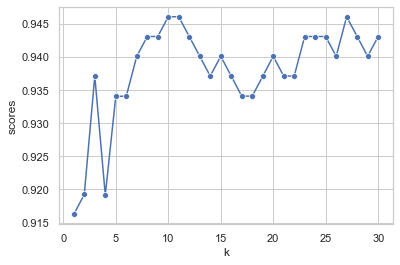

In [33]:
sns.lineplot(data = quality, x = "k", y = "scores", marker = 'o');

Судя по графику, самая высокая точность достигается при числе ближайших соседей $k=10$ (не только, но вы возьмем самое первое, наименьшее значение $k$, его будет достаточно). Попробуем выбрать такое $k$, перезапустить алгоритм на наших обучающей и тестовой выборках и оценить точность:

In [34]:
neigh = KNeighborsClassifier(n_neighbors = 10)
neigh.fit(X_train, y_train)
predicted = neigh.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predicted))

Accuracy:  0.9253731343283582


Точность немного увеличилась, ура!